In [87]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# 读取数据集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 处理 SalePrice 
prices = pd.DataFrame({'price':train['SalePrice'], 'log(price+1)':np.log1p(train['SalePrice'])})
# prices.hist()
train['SalePrice'] = np.log1p(train['SalePrice'])

# GrLivArea 
train['GrLivArea'] = train['GrLivArea'][train['GrLivArea']<4500]

# 合并训练集和测试机
all_data = pd.concat((train.loc[:,"MSSubClass":"SaleCondition"],
                     test.loc[:, "MSSubClass":"SaleCondition"]))

# 处理 偏斜>0.5
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# 转换成虚拟变量
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train["SalePrice"]



## Models
from sklearn.linear_model import Ridge, RidgeCV,ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline 

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse


"""
    Ridge
"""
# model_ridge = Ridge()
# alphas = [0.03, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 100]
# cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

# cv_ridge = pd.Series(cv_ridge, index=alphas)
# cv_ridge.plot(title = 'Validation - Just Do it')
# plt.xlabel('alpha')
# plt.ylabel('rmse')


"""
    Lasso
"""
# alphas = [1,0.3,0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00003,0.00001,0.000003]
# model_lasso = LassoCV(alphas=alphas, max_iter=50000).fit(X_train, y)
# rmse_cv(model_lasso).mean()
# preds = model_lasso.predict(X_test)
# solution = pd.DataFrame({'id':test.Id, 'SalePrice':np.expm1(preds)})
# solution.to_csv('linear_col.csv', index=False)

# for alpha in alphas:
#     model_lasso = LassoCV(alpha, max_iter=50000).fit(X_train, y)
#     res = rmse_cv(model_lasso)
#     print(alpha, res, res.mean())
# model_lasso = LassoCV(0.00001, max_iter=50000).fit(X_train, y)
# preds = model_lasso.predict(X_test)
# solution = pd.DataFrame({'id':test.Id, 'SalePrice':np.expm1(preds)})
# solution.to_csv('submission_2019_12_18.csv', index=False)

model_lasso = make_pipeline(RobustScaler(), LassoCV(0.00001, max_iter=50000))
model_lasso = model_lasso.fit(X_train, y)
print(rmse_cv(model_lasso))
preds = model_lasso.predict(X_test)
solution = pd.DataFrame({'id':test.Id, 'SalePrice':np.expm1(preds)})
solution.to_csv('submission_2019_12_18_2.csv', index=False)

[0.10466863 0.11766361 0.1245063  0.10769962 0.12454455]


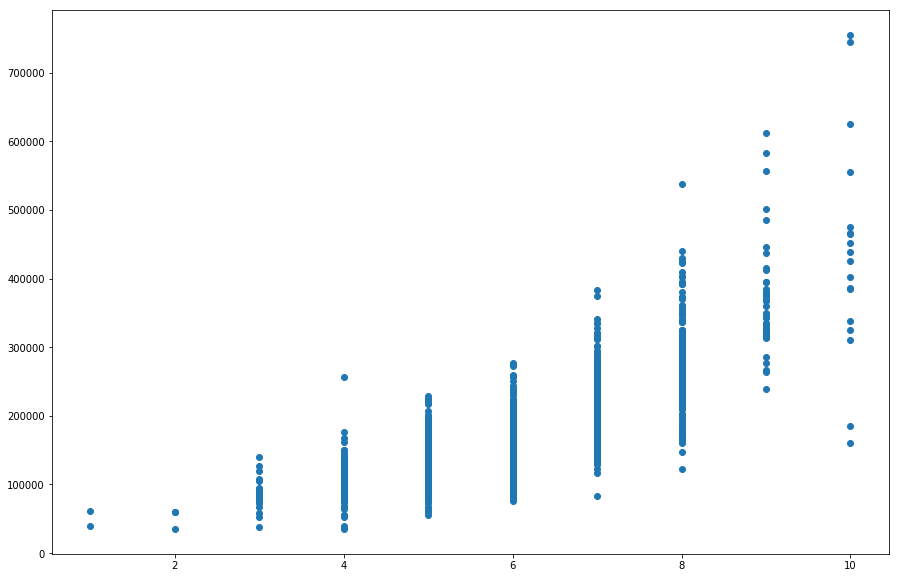

In [73]:
plt.subplots(figsize=(15,10))
plt.scatter(train['OverallQual'], np.expm1(train['SalePrice']))

In [3]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os


# print(os.listdir("../input"))

# Based on https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print('START data processing', datetime.now(), )

train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# ################## ML ########################################
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 
            0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, random_state=42, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

"""lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )"""
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)

# stack
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
#                                             gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)
                                

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lightgbm)
# print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


print('START Fit')
# print(datetime.now(), 'StackingCVRegressor')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
# print(datetime.now(), 'xgboost')
# xgb_model_full_data = xgboost.fit(X, y)
# print(datetime.now(), 'lightgbm')
# lgb_model_full_data = lightgbm.fit(X, y)

Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2019-12-19 22:36:19.364096
(2917, 79)
(2917, 86)
(2917, 333)
X (1458, 333) y (1458,) X_sub (1459, 333)
X (1453, 331) y (1453,) X_sub (1459, 331)
START ML 2019-12-19 22:36:20.733440
TEST score on CV
Kernel Ridge score: 0.1024 (0.0143)
 2019-12-19 22:37:21.773836
Lasso score: 0.1031 (0.0147)
 2019-12-19 22:37:44.018447
ElasticNet score: 0.1031 (0.0149)
 2019-12-19 22:39:17.836134
SVR score: 0.1023 (0.0133)
 2019-12-19 22:39:33.158991
START Fit
2019-12-19 22:39:33.160991 elasticnet
2019-12-19 22:39:43.185521 lasso
2019-12-19 22:39:45.402078 ridge
2019-12-19 22:39:51.828700 svr
2019-12-19 22:39:53.475116 GradientBoosting


In [11]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + 
            (0.05 * lasso_model_full_data.predict(X)) + 
            (0.1 * ridge_model_full_data.predict(X)) + 
            (0.1 * svr_model_full_data.predict(X)))
#             (0.1 * gbr_model_full_data.predict(X)) + 
#             (0.15 * xgb_model_full_data.predict(X))）
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.3 * stack_gen_model.predict(np.array(X))
            
            
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

print('Predict submission', datetime.now(),)
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# this kernel gave a score 0.114
# let's up it by mixing with the top kernels

# print('Blend with Top Kernals submissions', datetime.now(),)
# sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
# sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
# sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')
#sub_4 = pd.read_csv('../input/all-you-need-is-pca-lb-0-11421-top-4/submission.csv')
# sub_5 = pd.read_csv('../input/house-prices-solution-0-107-lb/submission.csv') # fork my kernel again)

submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub))))
#                                 (0.25 * sub_1.iloc[:,1]) + 
#                                 (0.25 * sub_2.iloc[:,1]) + 
#                                 (0.25 * sub_3.iloc[:,1]) 
                                #(0.15 * sub_4.iloc[:,1])  
                                #(0.1 * sub_5.iloc[:,1])
                                )


# From https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
# Brutal approach to deal with predictions close to outer range 
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)


submission.to_csv("House_price_submission_v57.csv", index=False)
print('Save submission', datetime.now(),)

RMSLE score on train data:
7.821449129039631
Predict submission 2019-12-19 22:48:39.682862
Save submission 2019-12-19 22:48:42.351534


In [14]:
np.floor([1,2,3])

array([1., 2., 3.])